In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [2]:

# Split dataset (if not already done)
train_src =r'E:\sanju\ASL_Alphabet_Dataset\asl_alphabet_train'
splitfolders.ratio(train_src, output="datasets/asl_alphabets", seed=1337, ratio=(.8, .1, .1), move=False)

Copying files: 223074 files [08:29, 437.64 files/s] 


In [3]:


# Paths
train_dir = r'E:\sanju\datasets\asl_alphabets\train'
val_dir   = r'E:\sanju\datasets\asl_alphabets\val'
test_dir  = r'E:\sanju\datasets\asl_alphabets\test'
input_shape = (64, 64, 1)
batch_size = 64


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,  # Avoid flipping ASL alphabet
    validation_split=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=False
)

# Labels
labels = list(train_generator.class_indices.keys())
num_classes = len(labels)





Found 178447 images belonging to 29 classes.
Found 22295 images belonging to 29 classes.
Found 22332 images belonging to 29 classes.


In [4]:
# 🔨 CNN Architecture (Improved)
model = models.Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # Output will be 32x32x32
    Dropout(0.25), # Start with a moderate dropout

    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # Output will be 32x32x32
    Dropout(0.25),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.35),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,075,101 (11.73 MB)

 Trainable params: 3,073,693 (11.73 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [6]:
# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)



In [7]:
# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.1148 - loss: 3.6833
Epoch 1: val_accuracy improved from -inf to 0.64243, saving model to best_model.keras
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 1298s 465ms/step - accuracy: 0.1149 - loss: 3.6831 - val_accuracy: 0.6424 - val_loss: 1.7250 - learning_rate: 0.0010
Epoch 2/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5625 - loss: 2.1130
Epoch 2: val_accuracy improved from 0.64243 to 0.81032, saving model to best_model.keras
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 1268s 455ms/step - accuracy: 0.5625 - loss: 2.1129 - val_accuracy: 0.8103 - val_loss: 1.4023 - learning_rate: 0.0010
Epoch 3/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7299 - loss: 1.6594
Epoch 3: val_accuracy improved from 0.81032 to 0.82458, saving model to best_model.keras
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 1278s 458ms/step - accuracy: 0.7299 - loss: 1.6594 - val_accuracy: 0.8246 - val_loss: 1.3257 - learning_rate: 0.0010
Epoch 4/30
2789/2789 ━

In [9]:

# Save final model
model.save("ANOTHER_SOME_CHANGES_NEW_MODEL.keras")

In [10]:
model.evaluate(test_generator)

349/349 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.9863 - loss: 0.3611


[0.3566655218601227, 0.9869245886802673]

In [13]:
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    """
    Load and preprocess the image to match model input
    """
    img = image.load_img(img_path, color_mode='grayscale', target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: Y (98.76%)


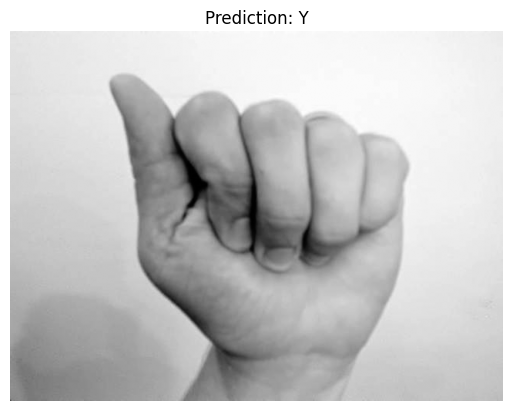

In [16]:
class_labels = list(train_generator.class_indices.keys())
def predict_asl(img_path):
    """
    Predict the ASL class for a given image path
    """
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    predicted_label = class_labels[class_index]
    confidence = np.max(prediction)

    print(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")

    # Show the image
    plt.imshow(image.load_img(img_path, color_mode='grayscale'), cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}")
    plt.show()

# Example usage
predict_asl(r"C:\Users\ramch\Downloads\AA.jpg")

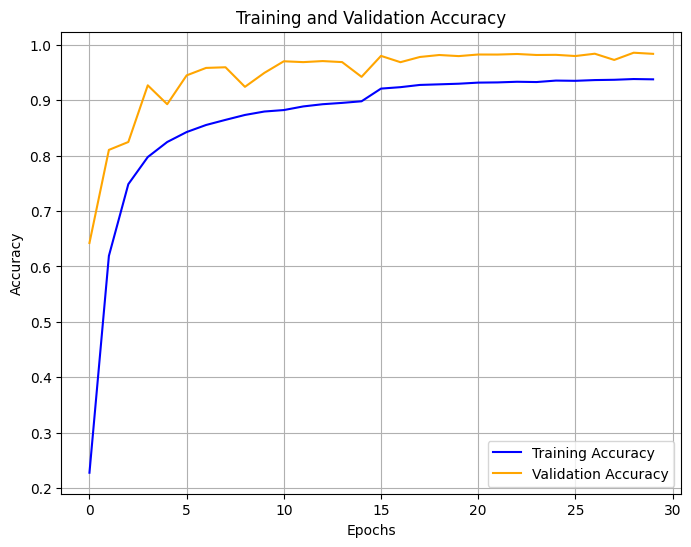

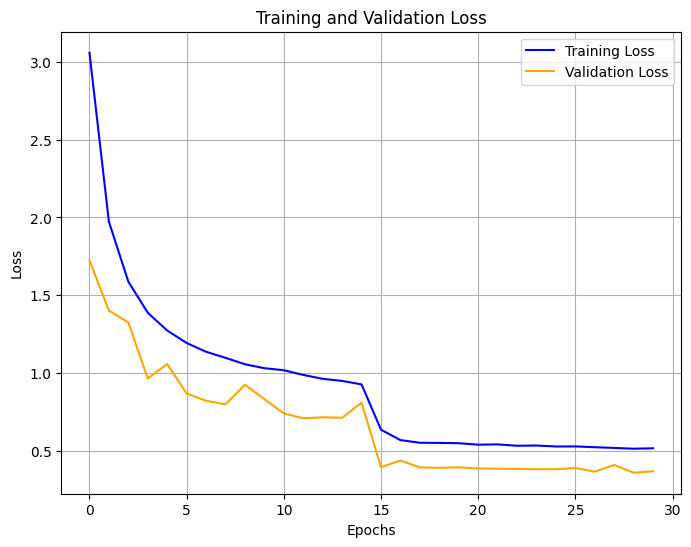

In [17]:
import matplotlib.pyplot as plt

# Assume you trained your model like:
# history = model.fit(train_data, validation_data=val_data, epochs=30)

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
